# skope_rules

https://skope-rules.readthedocs.io/en/latest/index.html

https://github.com/scikit-learn-contrib/skope-rules

In [44]:
import numpy as np
from collections.abc import Iterable
from collections import Counter
import pandas as pd
import numbers
from warnings import warn

from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils import indices_to_mask
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, GradientBoostingClassifier,\
    RandomForestClassifier
from sklearn.tree import _tree
import re
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix
from sklearn.datasets import load_boston, load_iris
from sklearn.cluster import AgglomerativeClustering
import warnings
from sklearn.model_selection import train_test_split
from matplotlib import cm

INTEGER_TYPES = (numbers.Integral, np.integer)
BASE_FEATURE_NAME = "__C__"

In [3]:
# функция замены общих имен функций реальными именами функций
def replace_feature_name(rule, replace_dict):
    def replace(match):
        return replace_dict[match.group(0)]

    rule = re.sub('|'.join(r'\b%s\b' % re.escape(s) for s in replace_dict),
                  replace, rule)
    return rule

# класс Правил
class Rule:
    """ Объект моделирует логическое правило и добавляет методы факторизации.
    Это используется для упрощения правил и их дедупликации.

    Параметры
    ----------
    rule : str
        Логическое правило, которое можно интерпретировать с помощью запроса pandas.
    args : object, optional
        Аргументы связанные с правилом, они не используются для факторизации,
        но принимают часть вывода когда правило преобразовывается в массив.
    """

    def __init__(self, rule, args=None):
        self.rule = rule
        self.args = args
        self.terms = [t.split(' ') for t in self.rule.split(' and ')]
        self.agg_dict = {}
        self.factorize()
        self.rule = str(self)

    # функция проверки одинаковых словарей
    def __eq__(self, other):
        return self.agg_dict == other.agg_dict

    # функция получения hash объектов
    def __hash__(self):
        # FIXME : Easier method ?
        return hash(tuple(sorted(((i, j) for i, j in self.agg_dict.items()))))

    # функция факторизации
    def factorize(self):
        for feature, symbol, value in self.terms:
            if (feature, symbol) not in self.agg_dict:
                if symbol != '==':
                    self.agg_dict[(feature, symbol)] = str(float(value))
                else:
                    self.agg_dict[(feature, symbol)] = value
            else:
                if symbol[0] == '<':
                    self.agg_dict[(feature, symbol)] = str(min(
                                float(self.agg_dict[(feature, symbol)]),
                                float(value)))
                elif symbol[0] == '>':
                    self.agg_dict[(feature, symbol)] = str(max(
                                float(self.agg_dict[(feature, symbol)]),
                                float(value)))
                else:  # Handle the c0 == c0 case
                    self.agg_dict[(feature, symbol)] = value

    # функция итераторов
    def __iter__(self):
        yield str(self)
        yield self.args

    # функция которая возвращает строковое представление правила
    def __repr__(self):
        return ' and '.join([' '.join(
                [feature, symbol, str(self.agg_dict[(feature, symbol)])])
                for feature, symbol in sorted(self.agg_dict.keys())
                ])


In [4]:
class SkopeRules(BaseEstimator):
    """Легко интерпретируемый классификатор, оптимизирующий простые логические правила.

    Параметры
    ----------

    feature_names : list of str, optional
        Список имен признаков, используемых для возвращения правил в строковом формате

    precision_min : float, optional (default=0.5)
        Минимальная точность(precision) с котороый правило будет выбрано.

    recall_min : float, optional (default=0.01)
        Минимальная полнота(recall)  с которой правило будет выбрано.

    n_estimators : int, optional (default=10)
        Количество деревьев в лесу(правил) которое будет использовано для предсказания.
        Еще больше строится перед отбором. Все доступно в аттрибуте estimators_.

    max_samples : int or float, optional (default=.8)
        Количество данных которое нужно взять из X для обучения каждого дерева решений,
        из которых правила генерируются и выбираются.
            - если int, тогда берется `max_samples` данных.
            - если float, тогда берется `max_samples * X.shape[0]` данных.
        Если max_samples больше чем размер предоставленных данных,
        все данные будут использоваться для всех деревьев.

    max_samples_features : int or float, optional (default=1.0)
        Количество признаков которое нужно извлечь из X для обучения каждого дерева решений,
        из которого создаются и выбираются правила.
            - если int, тогда выбирается `max_features` признаков.
            - если float, тогда выбирается `max_features * X.shape[1]` признаков.

    bootstrap : boolean, optional (default=False)
        Отбор наблюдений с возвращением.

    bootstrap_features : boolean, optional (default=False)
        Отбор признаков с возвращением.

    max_depth : integer or List or None, optional (default=3)
        Максимальная глубина деревьев решений. Если None, тогда узлы
        расширяются до тех пор, пока все листья не станут чистыми или пока
        все листья не будут содержать менее min_samples_split данных.
        Если итерация пройдена, вы обучите n_estimators для каждой глубины дерева.
        Это позволяет создавать и сравнивать правила разной длины.

    max_depth_duplication : integer, optional (default=None)
        Максимальная глубина дерева решений для дедупликации правил,
        если None то дедупликации не происходит.

    max_features : int, float, string or None, optional (default="auto")
        Количество признаков, рассматриваемых(каждым деревом решений)
        при поиске для лучшего разделения:
        - если int, тогда рассматриваем `max_features` признаков при каждом разделении.
        - если float, тогда `max_features` это процент и `int(max_features * n_features)` признаков
            рассматриваются при каждом разделении.
        - если "auto", тогда `max_features=sqrt(n_features)`.
        - если "sqrt", тогда `max_features=sqrt(n_features)` (тоже самое что и "auto").
        - если "log2", тогда `max_features=log2(n_features)`.
        - если None, тогда `max_features=n_features`.

        Примечание: поиск разбиения не прекращается до тех пор, пока не будет найден
        хотя бы один допустимый раздел образцов узлов, даже если для этого требуется
        эффективно проверить более чем ``max_features`` признаков.

    min_samples_split : int, float, optional (default=2)
        Минимальное количество данных необходимых для разделения внутреннего узла для каждого дерева решений.
        - если int, тогда считается `min_samples_split` как минимальное число.
        - если float, тогда `min_samples_split` это процент и
            `ceil(min_samples_split * n_samples)` минимальное количество данных для каждого разделения.
    n_jobs : integer, optional (default=1)
        Количество задач, которые будут выполняться параллельно как для `fit` и `predict`.
        Если -1, тогда число задач равно числу ядер процессора.

    random_state : int, RandomState instance or None, optional
        - если int, random_state это начальное число, используемое генератором случайных чисел.
        - если RandomState задается генератор случайных чисел.
        - если None, используется генератор случайных чисел из RandomState `np.random`.

    verbose : int, optional (default=0)
        Управляет детализацией процесса построения дерева.

    Аттрибуты
    ----------
    rules_ : dict of tuples (rule, precision, recall, nb).
        Коллекция `n_estimators`  правил используемых в методе ``predict``.
        Правила генерируются по подобранным sub-estimators(деревам решений).
        Каждое правило удовлетворяет условиям recall_min и precision_min.
        Выбор выполняется с соблюдением точности OOB(Out-of-bag).

    estimators_ : list of DecisionTreeClassifier
        Набор подобранных суб-оценок, используемых для создания правил-кандидатов.

    estimators_samples_ : list of arrays
        Подмножество отобранных данных (то есть данных из бэггинга) для каждого базового дерева.

    estimators_features_ : list of arrays
        Подмножество выбранных признаков для каждого базового дерева.

    max_samples_ : integer
        Актуальный размер данных.

    n_features_ : integer
        Количество признаков при выполнении  ``fit``.

    classes_ : array, shape (n_classes,)
        метки классов
    """

    def __init__(self,
                 feature_names=None,
                 precision_min=0.5,
                 recall_min=0.01,
                 n_estimators=10,
                 max_samples=.8,
                 max_samples_features=1.,
                 bootstrap=False,
                 bootstrap_features=False,
                 max_depth=3,
                 max_depth_duplication=None,
                 max_features=1.,
                 min_samples_split=2,
                 n_jobs=1,
                 random_state=None,
                 verbose=0):
        # минимальная точность
        self.precision_min = precision_min
        # минимальная полнота
        self.recall_min = recall_min
        # названия признаков
        self.feature_names = feature_names
        # количество деревьев решений
        self.n_estimators = n_estimators
        # актуальный размер данных
        self.max_samples = max_samples
        # максимальное количество признаков
        self.max_samples_features = max_samples_features
        # флаг бутстрепа
        self.bootstrap = bootstrap
        # флаг бутстрепа признаков
        self.bootstrap_features = bootstrap_features
        # максимальная глубина
        self.max_depth = max_depth
        # максимальная глубина дерева решений для дедупликации правил
        self.max_depth_duplication = max_depth_duplication
        # максимальное количество признаков для лучшего разделения
        self.max_features = max_features
        # минимальное количество данных для разделения внутреннего узла дерева
        self.min_samples_split = min_samples_split
        # количество потоков
        self.n_jobs = n_jobs
        # фиксация генератора случайных чисел
        self.random_state = random_state
        # режим детализации вывода
        self.verbose = verbose

    def fit(self, X, y, sample_weight=None):
        """Обучение модели в соответствии с заданными тренировочными данными.

        Параметры
        ----------
        X : array-like, shape (n_samples, n_features)
            Обучающий вектор, где n_samples количество данных и
            n_features количество признаков.

        y : array-like, shape (n_samples,)
            Целевой вектор относительно X. Должен быть размечен как 0 - для нормальных данных,
            1 - для аномалий.

        sample_weight : array-like, shape (n_samples,) optional
            Массив весов которые назначаются отдельным данным,
            обычно сумма в случае транзакционных данных. Используется для
            построения регрессионных деревьев для получения дополнительных правил для тестирования.
            Если не указан, то каждому образцу дается единичный вес.

        Returns
        -------
        self : object
            Returns self.
        """

        # проверка тренировочных данных на соответствие стандартам обучения scikit-learn
        X, y = check_X_y(X, y)
        # проверка целевого вектора что он не относится к регрессионому типу
        check_classification_targets(y)
        # количество признаков
        self.n_features_ = X.shape[1]
        # названия классов(меток)
        self.classes_ = np.unique(y)
        # общее число классов(меток)
        n_classes = len(self.classes_)

        # проверка, нужно 2 или более классов
        if n_classes < 2:
            raise ValueError("Этот метод требует выборки как минимум двух классов в данных,"
                             " но данные содержат только один класс  %r" % self.classes_[0])

        # ошибка если максимальная глубина дерева решений для дедупликации правил не задана как целое число int
        # и не является None
        if not isinstance(self.max_depth_duplication, int) \
                and self.max_depth_duplication is not None:
            raise ValueError("max_depth_duplication должно быть целым числом")

        # проверка на корректное задание меток класса
        if not set(self.classes_) == set([0, 1]):
            warn("Найденны метки %s. Этот метод предполагает, что целевой класс"
                 " должен быть помечен как 1, а обычные данные - как 0. Любая метка, отличная от 0,"
                 "будет считаться принадлежащей целевому классу."% set(self.classes_))
            y = (y > 0)

        # убедитесь что число данных находится в диапазоне [1, n_samples]
        n_samples = X.shape[0]

        # если актуальный размер данных задан как строка
        if isinstance(self.max_samples, str):
            raise ValueError('max_samples (%s) не поддерживается.'
                             'Допустимые варианты: "auto", int или'
                             'float' % self.max_samples)
        # если max_samples соответствует типу (<class 'numbers.Integral'>, <class 'numpy.integer'>)
        elif isinstance(self.max_samples, INTEGER_TYPES):
            if self.max_samples > n_samples:
                warn("max_samples (%s) больше чем "
                     "общее количество данных (%s). max_samples "
                     "будет установлено значение n_samples для оценки."
                     % (self.max_samples, n_samples))
                max_samples = n_samples
            else:
                max_samples = self.max_samples
        else:  # float
            if not (0. < self.max_samples <= 1.):
                raise ValueError("max_samples должен быть в (0, 1], получено %r"
                                 % self.max_samples)
            max_samples = int(self.max_samples * X.shape[0])
        # максимальное число входных данных
        self.max_samples_ = max_samples

        # словарь правил
        self.rules_ = {}
        # спикок оценщиков
        self.estimators_ = []
        # список данных оценщиков
        self.estimators_samples_ = []
        # спикок признаков оценщиков
        self.estimators_features_ = []

        #  имена стоблцов по умолчанию :
        feature_names_ = [BASE_FEATURE_NAME + x for x in
                          np.arange(X.shape[1]).astype(str)]
        if self.feature_names is not None:
            self.feature_dict_ = {BASE_FEATURE_NAME + str(i): feat
                                  for i, feat in enumerate(self.feature_names)}
        else:
            self.feature_dict_ = {BASE_FEATURE_NAME + str(i): feat
                                  for i, feat in enumerate(feature_names_)}
        self.feature_names_ = feature_names_

        # список BaggingClassifier
        clfs = []
        # спикок BaggingRegressor
        regs = []

        # максимальная глубина
        self._max_depths = self.max_depth \
            if isinstance(self.max_depth, Iterable) else [self.max_depth]

        # цикл до максимально заданной глубины
        for max_depth in self._max_depths:
            # построение ансамбля деревьев решений в помощью BaggingClassifier
            bagging_clf = BaggingClassifier(
                # берем классификатор дерева решений.
                base_estimator=DecisionTreeClassifier(
                    # максимальная глубина
                    max_depth=max_depth,
                    # максимальное количество признаков
                    max_features=self.max_features,
                    # минимальное количество данных для разделения внутреннего узла дерева
                    min_samples_split=self.min_samples_split),
                # количество деревьев решений
                n_estimators=self.n_estimators,
                # маскимальное количество данных
                max_samples=self.max_samples_,
                # максимальное количество признаков
                max_features=self.max_samples_features,
                # флаг бутстрепа
                bootstrap=self.bootstrap,
                # флаг бутстрепа признаков
                bootstrap_features=self.bootstrap_features,
                # oob_score=... XXX may be added
                # if selection on tree perf needed.
                # warm_start=... XXX may be added to increase computation perf.
                n_jobs=self.n_jobs,
                random_state=self.random_state,
                verbose=self.verbose)
            # построение ансамбля деревьев решений с помощью BaggingRegressor
            bagging_reg = BaggingRegressor(
                # берем регрессор дерева решений.
                base_estimator=DecisionTreeRegressor(
                    max_depth=max_depth,
                    max_features=self.max_features,
                    min_samples_split=self.min_samples_split),
                n_estimators=self.n_estimators,
                max_samples=self.max_samples_,
                max_features=self.max_samples_features,
                bootstrap=self.bootstrap,
                bootstrap_features=self.bootstrap_features,
                # oob_score=... XXX may be added
                # if selection on tree perf needed.
                # warm_start=... XXX may be added to increase computation perf.
                n_jobs=self.n_jobs,
                random_state=self.random_state,
                verbose=self.verbose)
            # добавляем в списки
            clfs.append(bagging_clf)
            regs.append(bagging_reg)

        # настройки по умолчанию целевого значения регрессии:
        # если веса заданы
        if sample_weight is not None:
            # проверка весов
            sample_weight = check_array(sample_weight, ensure_2d=False)
            weights = sample_weight - sample_weight.min()
            # загрязнение данных
            contamination = float(sum(y)) / len(y)
            y_reg = (
                    pow(weights, 0.5) * 0.5 / contamination * (y > 0) -
                    pow((weights).mean(), 0.5) * (y == 0))
            # сигмоида
            y_reg = 1. / (1 + np.exp(-y_reg))
        else:
            # такая же как и другой бэггинг классификации
            y_reg = y
        # проходимся циклом по списку классификаторов, обучаем ансамбли и сохраняем данные
        for clf in clfs:
            clf.fit(X, y)
            self.estimators_ += clf.estimators_
            self.estimators_samples_ += clf.estimators_samples_
            self.estimators_features_ += clf.estimators_features_

        # проходимся циклом по списку регрессии, обучаем ансамбли и сохраняем данные
        for reg in regs:
            reg.fit(X, y_reg)
            self.estimators_ += reg.estimators_
            self.estimators_samples_ += reg.estimators_samples_
            self.estimators_features_ += reg.estimators_features_

        # список правил
        rules_ = []
        for estimator, samples, features in zip(self.estimators_,
                                                self.estimators_samples_,
                                                self.estimators_features_):
            # Создание маски для  OOB выборок
            mask = ~indices_to_mask(samples, n_samples)
            #
            if sum(mask) == 0:
                warn("Оценка OOB невозможна: doing it in-bag."
                     " Оценка эффективности может быть неправильной"
                     " (переобучение) и выбранные правила скорее всего не будут работать!"
                     " Пожалуйста используйте max_samples < 1.")
                mask = samples
            # правила из дерева
            rules_from_tree = self._tree_to_rules(
                estimator, np.array(self.feature_names_)[features])

            # XXX todo: idem without dataframe
            X_oob = pd.DataFrame((X[mask, :])[:, features],
                                     columns=np.array(
                                         self.feature_names_)[features])

            if X_oob.shape[1] > 1:  # otherwise pandas bug (cf. issue #16363)
                y_oob = y[mask]
                y_oob = np.array((y_oob != 0))

                # Add OOB performances to rules:
                rules_from_tree = [(r, self._eval_rule_perf(r, X_oob, y_oob))
                                   for r in set(rules_from_tree)]
                rules_ += rules_from_tree

        # Факторизация правил до семантической фильтрации дерева
        rules_ = [
            tuple(rule)
            for rule in
            [Rule(r, args=args) for r, args in rules_]]

        # оставить только правила проверяющие  precision_min и recall_min:
        for rule, score in rules_:
            if score[0] >= self.precision_min and score[1] >= self.recall_min:
                if rule in self.rules_:
                    # обновить счет до нового среднего
                    c = self.rules_[rule][2] + 1
                    b = self.rules_[rule][1] + 1. / c * (
                            score[1] - self.rules_[rule][1])
                    a = self.rules_[rule][0] + 1. / c * (
                            score[0] - self.rules_[rule][0])

                    self.rules_[rule] = (a, b, c)
                else:
                    self.rules_[rule] = (score[0], score[1], 1)

        self.rules_ = sorted(self.rules_.items(),
                             key=lambda x: (x[1][0], x[1][1]), reverse=True)

        # Дедуплицирование правила используя семантическое дерево
        if self.max_depth_duplication is not None:
            self.rules_ = self.deduplicate(self.rules_)

        self.rules_ = sorted(self.rules_, key=lambda x: - self.f1_score(x))
        self.rules_without_feature_names_ = self.rules_

        # Замена общих имен функций реальными именами функций
        self.rules_ = [(replace_feature_name(rule, self.feature_dict_), perf)
                       for rule, perf in self.rules_]

        return self

    def predict(self, X):
        """Предсказание является ли конкретная выборка выбросом или нет.

        Параметры
        ----------
        X : array-like, shape (n_samples, n_features)
            Входные данные. Внутри они будут преобразованы в тип
            ``dtype=np.float32``

        Returns
        -------
        is_outlier : array, shape (n_samples,)
            Для каждого наблюдения сообщает так или иначе (1 или 0)  следует или нет
            данные рассматривать как выброс в соответствии с выбранными правилами.
        """

        return np.array((self.decision_function(X) > 0), dtype=int)

    def decision_function(self, X):
        """Средняя оценка аномальности X базовых классификаторов (правил).

        Оценка аномалии входной выборки вычисляется
        как взвешенная сумма выходных двоичных правил,
        причем вес является соответствующей точностью каждого правила.

        Параметры
        ----------
        X : array-like, shape (n_samples, n_features)
            Тренировочный набор данных.

        Returns
        -------
        scores : array, shape (n_samples,)
            Оценка аномалий входных данных.
            Чем выше, тем ненормальнее. Положительные оценки представляют собой выбросы,
            нулевые оценки представляют не выброс(inliers).
        """
        # Проверяем если был вызван метод fit
        check_is_fitted(self, ['rules_', 'estimators_', 'estimators_samples_',
                               'max_samples_'])

        # проверка входных данных
        X = check_array(X)

        if X.shape[1] != self.n_features_:
            raise ValueError("X.shape[1] = %d should be equal to %d, "
                             "the number of features at training time."
                             " Please reshape your data."
                             % (X.shape[1], self.n_features_))

        df = pd.DataFrame(X, columns=self.feature_names_)
        selected_rules = self.rules_without_feature_names_

        scores = np.zeros(X.shape[0])
        for (r, w) in selected_rules:
            scores[list(df.query(r).index)] += w[0]

        return scores

    def rules_vote(self, X):
        """Оценка, представляющая голосование базовых классификаторов (правил).

        Оценка входной выборки вычисляется
        как сумма выходных двоичных правил: оценка k означает, что k правил проголосовали положительно.

        Параметры
        ----------
        X : array-like, shape (n_samples, n_features)
            Тренировочный набор данных

        Returns
        -------
        scores : array, shape (n_samples,)
            Оценка исходных образцов.
            Чем выше, тем ненормальнее. Положительные оценки представляют собой выбросы,
            нулевые оценки представляют собой вставки(inliers).
        """
        # Проверяем если был вызван метод fit
        check_is_fitted(self, ['rules_', 'estimators_', 'estimators_samples_',
                               'max_samples_'])

        # Проверка входных данных
        X = check_array(X)

        if X.shape[1] != self.n_features_:
            raise ValueError("X.shape[1] = %d should be equal to %d, "
                             "the number of features at training time."
                             " Please reshape your data."
                             % (X.shape[1], self.n_features_))

        df = pd.DataFrame(X, columns=self.feature_names_)
        selected_rules = self.rules_

        scores = np.zeros(X.shape[0])
        for (r, _) in selected_rules:
            scores[list(df.query(r).index)] += 1

        return scores

    def score_top_rules(self, X):
        """Оценка, представляющая порядок между базовыми классификаторами (правилами).

        Оценка высока, когда экземпляр обнаруживается правилом выполнения.
        Если есть n правил, упорядоченных по возрастанию точности OOB,
        оценка k означает, что k-е правило проголосовало положительно,
        но не (k-1) первые правила.

        Параметры
        ----------
        X : array-like, shape (n_samples, n_features)
            Тренировочный набор данных

        Returns
        -------
        scores : array, shape (n_samples,)
            Оценка входных данных.
            Положительные баллы представляют выбросы, нулевые баллы - вставки(inliers).
        """
        # Проверяем если был вызван метод fit
        check_is_fitted(self, ['rules_', 'estimators_', 'estimators_samples_',
                               'max_samples_'])

        # Проверка входных данных
        X = check_array(X)

        if X.shape[1] != self.n_features_:
            raise ValueError("X.shape[1] = %d should be equal to %d, "
                             "the number of features at training time."
                             " Please reshape your data."
                             % (X.shape[1], self.n_features_))

        df = pd.DataFrame(X, columns=self.feature_names_)
        selected_rules = self.rules_without_feature_names_

        scores = np.zeros(X.shape[0])
        for (k, r) in enumerate(list((selected_rules))):
            scores[list(df.query(r[0]).index)] = np.maximum(
                len(selected_rules) - k,
                scores[list(df.query(r[0]).index)])

        return scores

    def predict_top_rules(self, X, n_rules):
        """Прогноз, является ли конкретная выборка выбросом,
         используя n_rules наиболее эффективных правил.

        Параметры
        ----------
        X : array-like, shape (n_samples, n_features)
            Входные данные. Внутри будут преобразованны в тип
            ``dtype=np.float32``

        n_rules : int
            Количество правил, используемых для прогноза.
            Если активировано одно из n_rules наиболее эффективных правил, прогноз равен 1.

        Returns
        -------
        is_outlier : array, shape (n_samples,)
            Для каждого наблюдения указывает, следует ли (1 или 0) рассматривать
            его как выброс в соответствии с выбранными правилами.
        """

        return np.array((self.score_top_rules(X) > len(self.rules_) - n_rules),
                        dtype=int)

    def _tree_to_rules(self, tree, feature_names):
        """
        Возвращает список правил из дерева

        Параметры
        ----------
            tree : дерево решений Classifier/Regressor
            feature_names: список признаков

        Возвращает
        -------
        rules : список правил.
        """
        # XXX todo: check the case where tree is build on subset of features,
        # ie max_features != None

        tree_ = tree.tree_
        feature_name = [
            feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
            for i in tree_.feature
        ]
        rules = []

        def recurse(node, base_name):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_name[node]
                symbol = '<='
                symbol2 = '>'
                threshold = tree_.threshold[node]
                text = base_name + ["{} {} {}".format(name, symbol, threshold)]
                recurse(tree_.children_left[node], text)

                text = base_name + ["{} {} {}".format(name, symbol2,
                                                      threshold)]
                recurse(tree_.children_right[node], text)
            else:
                rule = str.join(' and ', base_name)
                rule = (rule if rule != ''
                        else ' == '.join([feature_names[0]] * 2))
                # правило выбора всех установлено "c0==c0"
                rules.append(rule)

        recurse(0, [])

        return rules if len(rules) > 0 else 'True'

    # функция вычисления производительности правила
    def _eval_rule_perf(self, rule, X, y):
        detected_index = list(X.query(rule).index)
        if len(detected_index) <= 1:
            return (0, 0)
        y_detected = y[detected_index]
        true_pos = y_detected[y_detected > 0].sum()
        if true_pos == 0:
            return (0, 0)
        pos = y[y > 0].sum()
        return y_detected.mean(), float(true_pos) / pos

    # функция вычисления дедупликации правил
    def deduplicate(self, rules):
        return [max(rules_set, key=self.f1_score)
                for rules_set in self._find_similar_rulesets(rules)]

    def _find_similar_rulesets(self, rules):
        """Создавайте кластеры правил используя деревья решений на основе условий правил

        Параметры
        ----------
        rules : List, List of rules
                Правила, которые следует разделить на подмножества похожих правил

        Returns
        -------
        rules : List of list of rules
                Разное множество правил. Каждое множество должно быть однородным

        """

        def split_with_best_feature(rules, depth, exceptions=[]):
            """
            Метод поиска разделения правил с учетом наиболее репрезентативных признаков
            """
            if depth == 0:
                return rules

            rulelist = [rule.split(' and ') for rule, score in rules]
            terms = [t.split(' ')[0] for term in rulelist for t in term]
            counter = Counter(terms)
            # Удалить список исключений
            for exception in exceptions:
                del counter[exception]

            if len(counter) == 0:
                return rules

            most_represented_term = counter.most_common()[0][0]
            # Приступить к разделению
            rules_splitted = [[], [], []]
            for rule in rules:
                if (most_represented_term + ' <=') in rule[0]:
                    rules_splitted[0].append(rule)
                elif (most_represented_term + ' >') in rule[0]:
                    rules_splitted[1].append(rule)
                else:
                    rules_splitted[2].append(rule)
            new_exceptions = exceptions + [most_represented_term]
            # Выбрать лучшее term
            return [split_with_best_feature(ruleset,
                                            depth - 1,
                                            exceptions=new_exceptions)
                    for ruleset in rules_splitted]
        # поиск в ширину по дереву
        def breadth_first_search(rules, leaves=None):
            if len(rules) == 0 or not isinstance(rules[0], list):
                if len(rules) > 0:
                    return leaves.append(rules)
            else:
                for rules_child in rules:
                    breadth_first_search(rules_child, leaves=leaves)
            return leaves

        leaves = []
        res = split_with_best_feature(rules, self.max_depth_duplication)
        breadth_first_search(res, leaves=leaves)
        return leaves

    # функция расчета f1 метрики
    def f1_score(self, x):
        return 2 * x[1][0] * x[1][1] / \
               (x[1][0] + x[1][1]) if (x[1][0] + x[1][1]) > 0 else 0

`Документация`: https://skope-rules.readthedocs.io/en/latest/index.html

Skope-rules нацелены на изучение логических,
интерпретируемых правил для «определения области действия» целевого класса,
то есть обнаружения с высокой точностью экземпляров этого класса.
SkopeRules можно использовать для описания классов с помощью логических правил.

SkopeRules - позволяет получить логические правила при классификации, подходит для
классификации несбалансированных классов, обнаружить аномалии.

### Описание классов с помощью логических правил

In [10]:
# загружаем набор данных Ирисов Фишера
dataset = load_iris()
# имена признаков
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

feature_names_ru = ['длина наружной доли околоцветника', 'ширина наружной доли околоцветника ',
                 'длина внутренней доли околоцветника', 'ширина внутренней доли околоцветника']
dct_feature_names_ru = dict(zip(feature_names, feature_names_ru))
for k,v in dct_feature_names_ru.items():
    print(f'{k} - {v}')
print(100*'*')
dct_ru_names_iris = {'setosa': 'ирис щетинистый', 'versicolor': 'ирис разноцветный', 'virginica': 'ирис виргинский'}
clf = SkopeRules(max_depth_duplication=2,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=feature_names)

for idx, species in enumerate(dataset.target_names):
    X, y = dataset.data, dataset.target
    clf.fit(X, y == idx)
    rules = clf.rules_[0:3]
    print("Правило:", dct_ru_names_iris[species])
    for rule in rules:
        print(rule)
    print()
    print(100 * '=')
    print()

sepal_length - длина наружной доли околоцветника
sepal_width - ширина наружной доли околоцветника 
petal_length - длина внутренней доли околоцветника
petal_width - ширина внутренней доли околоцветника
****************************************************************************************************
Правило: ирис щетинистый
('petal_width <= 0.800000011920929', (1.0, 1.0, 20))
('petal_length <= 2.449999988079071', (1.0, 1.0, 24))


Правило: ирис разноцветный
('petal_length <= 4.950000047683716 and petal_length > 2.449999988079071 and petal_width <= 1.75', (1.0, 1.0, 4))
('sepal_length > 4.950000047683716 and petal_length <= 4.8500001430511475 and petal_width > 0.800000011920929', (0.8461538461538461, 0.9166666666666666, 1))
('sepal_length <= 7.099999904632568 and petal_length > 2.449999988079071 and petal_width <= 1.75', (0.75, 1.0, 1))


Правило: ирис виргинский
('petal_length > 4.75 and petal_width > 1.75', (0.8819444444444444, 1.0, 2))
('petal_width > 1.75', (0.9077777777777778, 0.8

### Использование в качестве описания кластеров

пример: https://github.com/scikit-learn-contrib/skope-rules/blob/master/notebooks/demo_clustering.ipynb

Данные `CompleteDataset.csv`: https://www.kaggle.com/thec03u5/fifa-18-demo-player-dataset/data. 

Датасет описывает футболистов и их характеристики.

In [38]:
warnings.filterwarnings('ignore')
data = pd.read_csv('CompleteDataset.csv')
# Выберем игроков с общим атрибутом больше 85/100.
data = data.query("Overall>=85")

column_to_keep = ['Name', 'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking',
       'GK positioning', 'GK reflexes', 'Heading accuracy', 'Preferred Positions']
# Сохраним только атрибуты производительности и имена.
data = data[column_to_keep]

# Заменим пробелы в именах столбцов
data.columns = [x.replace(' ', '_') for x in data.columns]

feature_names = data.drop(['Name', 'Preferred_Positions'], axis=1).columns.tolist()

In [39]:
# Получаем 4 кластера
clust = AgglomerativeClustering(n_clusters=4)
data['cluster'] = clust.fit_predict(data.drop(['Name', 'Preferred_Positions'], axis=1))

In [40]:
# Проходим в цикле по каждому кластеру отдельно и выводим правила
i_cluster = 0
for i_cluster in range(4):
    X_train = data.drop(['Name', 'Preferred_Positions', 'cluster'], axis=1)
    y_train = (data['cluster']==i_cluster)*1
    skope_rules_clf = SkopeRules(feature_names=feature_names, random_state=42, n_estimators=5,
                                   recall_min=0.5, precision_min=0.5, max_depth_duplication=0,
                                   max_samples=1., max_depth=3)
    skope_rules_clf.fit(X_train, y_train)
    print('Cluster '+str(i_cluster)+':')
    #print(data.query('cluster=='+str(i_cluster))[['Name', 'Preferred_Positions']])
    print(skope_rules_clf.rules_)

Cluster 0:
[('Free_kick_accuracy > 56.0 and Heading_accuracy > 58.5 and Agility <= 81.5', (0.9354838709677419, 0.8529411764705882, 10))]
Cluster 1:
[('Aggression <= 76.5 and Agility > 81.5 and Balance > 66.5', (1.0, 0.7741935483870968, 8))]
Cluster 2:
[('Heading_accuracy > 82.5 and Curve <= 61.5', (1.0, 0.7857142857142857, 8))]
Cluster 3:
[('Curve <= 28.0', (1.0, 1.0, 4))]


В `кластере 0` мы находим игроков с хорошей игрой головой и точностью в штрафных, но не самых ловких игроков (<= 81/100). 

Это правило хорошо описывает кластер 0: он захватывает 85% кластера 1 с точностью 93% (7% игроков, описываемых правилом, не входят в кластер 0). Третий член показателя производительности (10) - это количество раз, когда это правило было извлечено из деревьев, построенных во время подбора правил skope.

В `кластере 1` мы находим очень гибких игроков, которые не самые агрессивные, но уравновешенные. Это правило очень точное, но не учитывает 23% этого кластера.

В `кластере 2` мы находим игроков, которые с точной игрой головой, но с меньшими навыками ведения дриблинга (кривая).

В `кластере 3` мы находим игроков, которые очень плохо ведут мяч. Это правило идеально определяет кластер (100% точность, 100% отзыв). Это вратарская группа.

In [41]:
for i_cluster in range(4):
    print('5 players from cluster '+str(i_cluster)+':')
    print(data.query("cluster=="+str(i_cluster))['Name'].sample(5, random_state=42).tolist()) # Get 5 random players per cluster
    print()

5 players from cluster 0:
['M. Hamšík', 'Alex Sandro', 'Casemiro', 'K. Benzema', 'Z. Ibrahimović']

5 players from cluster 1:
['H. Mkhitaryan', 'David Silva', 'F. Ribéry', 'J. Rodríguez', 'P. Dybala']

5 players from cluster 2:
['Pepe', 'K. Glik', 'G. Chiellini', 'V. Kompany', 'Piqué']

5 players from cluster 3:
['M. ter Stegen', 'D. Subašić', 'M. Neuer', 'K. Navas', 'H. Lloris']



Короче говоря, `кластер 0` имеет тенденцию концентрировать нападающих и полузащитников, талантливых своей головой. `Кластер 1` имеет тенденцию группировать других полузащитников. `Кластер 2` сосредоточен на защитниках, а вратари собираются в `кластере 3`.

### Решение проблемы бинарной классификации на примере данных titanic

пример: https://github.com/scikit-learn-contrib/skope-rules/blob/master/notebooks/demo_titanic.ipynb

In [45]:
# скачаем данные
!kaggle competitions download -c titanic

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 1.69MB/s]


In [46]:
# распакуем архив
!unzip titanic.zip -d data

Archive:  titanic.zip
  inflating: data/gender_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [47]:
data = pd.read_csv('data/train.csv')
# удалим строки без возраста
data = data.query('Age == Age')

# создадим dummy для переменой Sex
data['isFemale'] = (data['Sex'] == 'female') * 1

# Создадим dummies для переменной Embarked
data = pd.concat(
    [data,
    pd.get_dummies(data.loc[:,'Embarked'], dummy_na=False, prefix='Embarked', prefix_sep='_')],
    axis=1
)

# удалим неиспользуемые колонки
data = data.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Sex', 'Embarked'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Survived'], axis=1), data['Survived'], test_size=0.25, random_state=42)
feature_names = X_train.columns

print('Column names are: ' + ' '.join(feature_names.tolist())+'.')
print('Shape of training set is: ' + str(X_train.shape) + '.')

Column names are: Pclass Age SibSp Parch Fare isFemale Embarked_C Embarked_Q Embarked_S.
Shape of training set is: (535, 9).


In [48]:
# Train a gradient boosting classifier for benchmark
gradient_boost_clf = GradientBoostingClassifier(random_state=42, n_estimators=30, max_depth = 5)
gradient_boost_clf.fit(X_train, y_train)

# Train a random forest classifier for benchmark
random_forest_clf = RandomForestClassifier(random_state=42, n_estimators=30, max_depth = 5)
random_forest_clf.fit(X_train, y_train)

# Train a decision tree classifier for benchmark
decision_tree_clf = DecisionTreeClassifier(random_state=42, max_depth = 5)
decision_tree_clf.fit(X_train, y_train)

# Train a skope-rules-boosting classifier
skope_rules_clf = SkopeRules(feature_names=feature_names, random_state=42, n_estimators=30,
                               recall_min=0.05, precision_min=0.9,
                               max_samples=0.7,
                               max_depth_duplication= 4, max_depth = 5)
skope_rules_clf.fit(X_train, y_train)


# Compute prediction scores
gradient_boost_scoring = gradient_boost_clf.predict_proba(X_test)[:, 1]
random_forest_scoring = random_forest_clf.predict_proba(X_test)[:, 1]
decision_tree_scoring = decision_tree_clf.predict_proba(X_test)[:, 1]

skope_rules_scoring = skope_rules_clf.score_top_rules(X_test)

In [52]:
# Выведем число правил для выживания
print(str(len(skope_rules_clf.rules_)) + ' правила были построены с помощью ' +
      'SkopeRules.\n')


rules_explanations = [
    'Женщины в возрасте до 3 и 37, которые были в первом или втором классе.',
    'Женщины в возрасте более 3 лет в первом или втором классе, которые заплатили более 26€.',
    'Женщины первого или второго класса, которые платили больше, чем 29€.',
    'Женщины старше 39 лет, в первом или втором классе.'
]
print('4 наиболее эффективных "правила выживания Титаника" заключаются в следующем:\n')
for i_rule, rule in enumerate(skope_rules_clf.rules_[:4]):
    print(rule[0])
    print('-> '+rules_explanations[i_rule]+ '\n')

9 правила были построены с помощью SkopeRules.

4 наиболее эффективных "правила выживания Титаника" заключаются в следующем:

Pclass <= 2.5 and Age <= 37.0 and Age > 2.5 and isFemale > 0.5
-> Женщины в возрасте до 3 и 37, которые были в первом или втором классе.

Pclass <= 2.5 and Age > 2.5 and Fare > 26.125 and isFemale > 0.5
-> Женщины в возрасте более 3 лет в первом или втором классе, которые заплатили более 26€.

Pclass <= 2.5 and Fare > 29.356249809265137 and isFemale > 0.5
-> Женщины первого или второго класса, которые платили больше, чем 29€.

Pclass <= 2.5 and Age > 38.5 and isFemale > 0.5
-> Женщины старше 39 лет, в первом или втором классе.



In [53]:
def compute_y_pred_from_query(X, rule):
    score = np.zeros(X.shape[0])
    X = X.reset_index(drop=True)
    score[list(X.query(rule).index)] = 1
    return(score)

def compute_performances_from_y_pred(y_true, y_pred, index_name='default_index'):
    df = pd.DataFrame(data=
        {
            'precision':[sum(y_true * y_pred)/sum(y_pred)],
            'recall':[sum(y_true * y_pred)/sum(y_true)]
        },
        index=[index_name],
        columns=['precision', 'recall']
    )
    return(df)

def compute_train_test_query_performances(X_train, y_train, X_test, y_test, rule):
    
    y_train_pred = compute_y_pred_from_query(X_train, rule)
    y_test_pred = compute_y_pred_from_query(X_test, rule)
    
    performances = None
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_train, y_train_pred, 'train_set')],
        axis=0)
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_test, y_test_pred, 'test_set')],
        axis=0)
            
    return(performances)


print('Точность = 0.96 означает, что 96% людей, идентифицированных по этому правилу, являются выжившими.')
print('Полнота = 0.12 означает, что выжившие, идентифицированные правилом, составляют 12% от общего числа выживших.\n')

for i in range(4):
    print('Правило '+str(i+1)+':')
    display(compute_train_test_query_performances(X_train, y_train,
                                                  X_test, y_test,
                                                  skope_rules_clf.rules_[i][0])
           )

Точность = 0.96 означает, что 96% людей, идентифицированных по этому правилу, являются выжившими.
Полнота = 0.12 означает, что выжившие, идентифицированные правилом, составляют 12% от общего числа выживших.

Правило 1:


,precision,recall
train_set,0.974026,0.344037
test_set,0.928571,0.361111


Правило 2:


,precision,recall
train_set,0.986667,0.339450
test_set,0.960000,0.333333


Правило 3:


,precision,recall
train_set,0.985507,0.311927
test_set,0.950000,0.263889


Правило 4:


,precision,recall
train_set,0.942857,0.151376
test_set,0.923077,0.166667


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


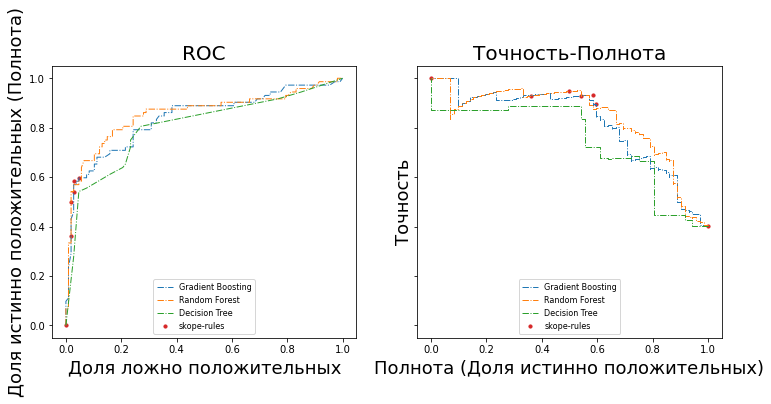

In [54]:
def plot_titanic_scores(y_true, scores_with_line=[], scores_with_points=[],
                        labels_with_line=['Gradient Boosting', 'Random Forest', 'Decision Tree'],
                        labels_with_points=['skope-rules']):
    gradient = np.linspace(0, 1, 10)
    color_list = [ cm.tab10(x) for x in gradient ]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5),
                         sharex=True, sharey=True)
    ax = axes[0]
    n_line = 0
    for i_score, score in enumerate(scores_with_line):
        n_line = n_line + 1
        fpr, tpr, _ = roc_curve(y_true, score)
        ax.plot(fpr, tpr, linestyle='-.', c=color_list[i_score], lw=1, label=labels_with_line[i_score])
    for i_score, score in enumerate(scores_with_points):
        fpr, tpr, _ = roc_curve(y_true, score)
        ax.scatter(fpr[:-1], tpr[:-1], c=color_list[n_line + i_score], s=10, label=labels_with_points[i_score])
    ax.set_title("ROC", fontsize=20)
    ax.set_xlabel('Доля ложно положительных', fontsize=18)
    ax.set_ylabel('Доля истинно положительных (Полнота)', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)

    ax = axes[1]
    n_line = 0
    for i_score, score in enumerate(scores_with_line):
        n_line = n_line + 1
        precision, recall, _ = precision_recall_curve(y_true, score)
        ax.step(recall, precision, linestyle='-.', c=color_list[i_score], lw=1, where='post', label=labels_with_line[i_score])
    for i_score, score in enumerate(scores_with_points):
        precision, recall, _ = precision_recall_curve(y_true, score)
        ax.scatter(recall, precision, c=color_list[n_line + i_score], s=10, label=labels_with_points[i_score])
    ax.set_title("Точность-Полнота", fontsize=20)
    ax.set_xlabel('Полнота (Доля истинно положительных)', fontsize=18)
    ax.set_ylabel('Точность', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)
    plt.show()
    
plot_titanic_scores(y_test,
                    scores_with_line=[gradient_boost_scoring, random_forest_scoring, decision_tree_scoring],
                    scores_with_points=[skope_rules_scoring]
                   )

На кривой `ROC` каждая красная точка соответствует ряду активированных правил (из skope-rules).
Например, самая низкая точка - это оценка эффективности для 1 правила (лучшая). Вторая самая низкая точка - это график для 2 правила и т. д.

На кривой Точность-Полнота(Precision-Recall) нанесены одни и те же точки, но с разными осями. Предупреждение: первая красная точка слева (отзыв 0%, точность 100%) соответствует правилу 0. Второй пункт слева - это первое правило и т. д.

Из этого примера можно сделать некоторые выводы:

* skope-rules работает лучше, чем дерево решений.
* skope-rules имеют те же характеристики, что и усиление случайного леса / градиента (в этом примере)
* Использование 4 правил приводит к отличной производительности (61% отзыв, 94% точность) (в этом примере).

In [55]:
n_rule_chosen = 4
y_pred = skope_rules_clf.predict_top_rules(X_test, n_rule_chosen)

print('Показатели достигнуты с '+str(n_rule_chosen)+' обнаруженные правила следующие:')
compute_performances_from_y_pred(y_test, y_pred, 'test_set')

Показатели достигнуты с 4 обнаруженные правила следующие:


,precision,recall
test_set,0.928571,0.541667
